In [1]:
import bandit as b
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from BaseAgent import AbstractAgent
np.random.seed(290)

C:\Users\saraa\AppData\Local\Temp\ipykernel_28380\313546155.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Multi-Armed Bandits: 

Three medicine where the effectiveness varies randomly over time. 

non-stationary MAB scenario? bc the reward distributions are changing over time.

In [2]:
bandit_final_env =b.Bandits_final()

In [3]:
bandit_final_env.reset()
bandit_final_env.step(0)
bandit_final_env.step(0)
bandit_final_env.step(2)

bandit_final_env.reset()
bandit_final_env.step(1)
bandit_final_env.step(2)
bandit_final_env.step(1)

bandit_final_env.reset()
# @shania burde kanskje lage ny env for hver ny window paramter og sånt...
# bare reset() ser ut til å huske ting fra forrige run

(None, 0, False, False, {'steps': 6})

In [4]:
#@shania this and next not same...
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 2.2933785872233985, True, False, {'steps': 1})

In [5]:
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 1.2798418929944861, True, False, {'steps': 1})

In [6]:
#@shania but this and next do be the same!
# gjør at det er helt likt med nye means og sånt for hver av paramterne du prøver
np.random.seed(290)
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 3.4770007318359246, True, False, {'steps': 1})

In [7]:
np.random.seed(290)
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 3.4770007318359246, True, False, {'steps': 1})

The agent implements a variant of the Upper Confidence Bound (UCB) algorithm, a popular method in multi-armed bandit problems. It uses a sliding window mechanism to adapt to potentially non-stationary environments (where the properties of the environment can change over time).

1. Action Selection with UCB: This part calculates the Upper Confidence Bound for each action (or "arm") based on recent rewards. It balances exploration (trying new actions) and exploitation (using actions known to yield high rewards). Actions with fewer trials or high uncertainty get a "bonus" to their estimated value, encouraging exploration.
2. Sliding Window: This mechanism ensures that the agent's decisions are based on recent experiences by maintaining a fixed-size list of the most recent rewards for each action. This helps adapt to changes in the environment's dynamics.
3. Learning from Interaction: After performing an action and observing a reward, the agent updates its knowledge (the sliding windows of rewards)

In [8]:
class SlidingWindowUCB:
    def __init__(self, k, window_size=50, c=1):
        self.k = k
        self.window_size = window_size
        self.c = c
        self.windows = {i: [] for i in range(k)}
        self.t = 0
    
    def select_action(self):
        self.t += 1
        ucb_values = []
        for arm in range(self.k):
            rewards = self.windows[arm]
            if len(rewards) < 1:
                ucb_values.append(float('inf'))
            else:
                mean_reward = np.mean(rewards)
                bonus = self.c * np.sqrt(np.log(self.t) / len(rewards))
                ucb_values.append(mean_reward + bonus)
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        rewards = self.windows[action]
        if len(rewards) >= self.window_size:
            rewards.pop(0)
        rewards.append(reward)


In [9]:
def sliding_window_ucb(env, k, window_sizes, cs, num_episodes=1000):
    results = {}
    for window_size in window_sizes:
        for c in cs:
            agent = SlidingWindowUCB(k=k, window_size=window_size, c=c)
            total_rewards = 0
            rewards_per_episode = []  # Optional: track rewards for each episode

            for episode in range(num_episodes):
                obs, reward, terminated, _,_ = env.reset()  # Initial reset for each episode
                episode_reward = 0  # Reset episode reward
                

                #@shania blir terminated med en gang, så while kun en gang...
                while not terminated:
                    action = agent.select_action()
                    _, reward, terminated, _, _ = env.step(action)
                    agent.update(action, reward)
                    episode_reward += reward
                
                total_rewards += episode_reward
                rewards_per_episode.append(episode_reward)  # Store episode reward

            avg_reward = total_rewards / num_episodes
            results[(window_size, c)] = {
                'total_rewards': total_rewards,
                'average_reward': avg_reward,
                'rewards_per_episode': rewards_per_episode
            }
            print(f"Window Size: {window_size}, c: {c}, Total Reward: {total_rewards}, Average Reward: {avg_reward}")

    return results

# Example usage of the function
env = bandit_final_env  # This should be your environment instance
k = 3  # Number of actions
window_sizes = [20, 50, 100]  # Different window sizes to test
cs = [0.5, 2]  # Different values of exploration parameter c to test
test_results = sliding_window_ucb(env, k, window_sizes, cs)


Window Size: 20, c: 0.5, Total Reward: 4384.188824997163, Average Reward: 4.384188824997162
Window Size: 20, c: 2, Total Reward: 4320.378055040314, Average Reward: 4.320378055040314
Window Size: 50, c: 0.5, Total Reward: 3102.9070103855024, Average Reward: 3.1029070103855023
Window Size: 50, c: 2, Total Reward: 3998.7724765821395, Average Reward: 3.9987724765821393
Window Size: 100, c: 0.5, Total Reward: 4758.091899824198, Average Reward: 4.758091899824198
Window Size: 100, c: 2, Total Reward: 3934.8778084827836, Average Reward: 3.9348778084827836


In [10]:
test_results

{(20, 0.5): {'total_rewards': 4384.188824997163,
  'average_reward': 4.384188824997162,
  'rewards_per_episode': [4.304819668893541,
   5.290781705499748,
   -2.5127378823153124,
   2.425980672845981,
   6.135005351997471,
   4.657822462366424,
   3.170155714203659,
   4.86121125428436,
   3.3970479500615633,
   4.870214991420307,
   4.900199533678152,
   4.566851349368569,
   3.4053350858180114,
   3.1834462272647337,
   2.914878106627574,
   4.204653415535094,
   2.234708287153947,
   2.6562509891480293,
   4.29074411823918,
   3.7556365021215132,
   3.520606255038028,
   3.4820918627626294,
   3.011201961605898,
   4.560568826309711,
   3.558435751428229,
   1.962637779125564,
   4.481168788797225,
   2.981409921511858,
   4.471222889800499,
   4.190852489825211,
   6.080707287940676,
   3.326337426760729,
   3.631524235161863,
   3.423039883981457,
   3.8680358217127333,
   3.614650607988358,
   3.5756659904934747,
   3.3482459364481065,
   2.9183744197081083,
   3.4812250340134163

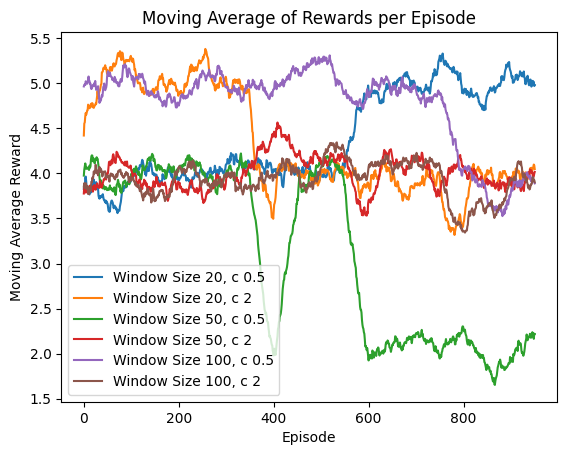

In [11]:

rolling_window = 50  

# Plotting setup
fig, ax = plt.subplots()

for (ws, c), data in test_results.items():
    rewards = np.array(data['rewards_per_episode'])
    # Compute the moving average using the convolve method
    moving_average = np.convolve(rewards, np.ones(rolling_window)/rolling_window, mode='valid')
    # Plot each series with a label indicating the window size and c value
    ax.plot(moving_average, label=f"Window Size {ws}, c {c}")

# Chart formatting
ax.set_title('Moving Average of Rewards per Episode')
ax.set_xlabel('Episode')
ax.set_ylabel('Moving Average Reward')
ax.legend()
plt.show()


In [12]:
#@shania oppg 3, #run the proposed solution *alongside* one of the standard MAB algorithms and compare"
# ser du har brukt sliding window med ucb, men er meningen å sammenligne slidingwindow+ucb med kun ucb og greedy etc?? eller slidingwindow+ucb med slidingwindow+greedy etc???
# altså TODO: find results to compare!!!

# Decay epsilon greedy:

In [13]:
def calculate_regret(mab, cumulative_reward, t, print_=False):
    if mab.state is not None:
        optimal_reward = mab.means[mab.state][mab.get_optimal_action()] * t
    else:
        optimal_reward = mab.means[mab.get_optimal_action()] * t
    #if print_:
       # print("optimal reward at time step", t, ":", optimal_reward)
        #print("cumulative reward at time step", t, ":", cumulative_reward)
    return optimal_reward - cumulative_reward

 
def update_expected_reward(expected_reward,action_count,current_action,reward):
    expected_reward[current_action]+=(1/action_count[current_action]) * (reward-expected_reward[current_action])

def get_confidence_bounds(t,action_count):
    return np.sqrt(2*np.log(t)/action_count)
## here i am calculating the 


In [14]:
def decaying_epsilon_greedy(mab,T,epsilon, alpha,print_=False):
    mab.reset()

    # initialise the expected reward and action count and cumulative reward
    expected_reward = np.ones(mab.k)*100
    action_count = np.zeros(mab.k)
    cumulative_rewards = 0
    
    for _ in range(T):
        if np.random.uniform(0,1) < epsilon:
            current_action = np.random.randint(mab.k)
        else:
            current_action = np.argmax(expected_reward)
            
        current_state = mab.step(current_action)        # maybe not state...
        cumulative_rewards += current_state[1]
        action_count[current_action] += 1
        update_expected_reward(expected_reward,action_count,current_action,current_state[1])
        epsilon*=alpha
    
    if print_:
        for i in range(mab.k):
            print("Expected reward action", i, ":", expected_reward[i], "Action count:", action_count[i])

    regret = calculate_regret(mab, cumulative_rewards, T,print_)   

    if print_:
        print('-------------------------------------\n\n')

    return np.argmax(expected_reward), regret

In [15]:
print(decaying_epsilon_greedy(bandit_final_env,1000,0.5,0.99))

(0, 233.34611291421788)


In [16]:
def epsilon_greedy(mab,T,epsilon,print_=False):
    mab.reset()

    # initialise the expected reward and action count and cumulative reward
    expected_reward = np.ones(mab.k)*1000
    action_count = np.zeros(mab.k)
    cumulative_rewards = 0
    regret2 = np.zeros(T)
    
    for t in range(T):
        if np.random.uniform(0,1) < epsilon:
            current_action = np.random.randint(mab.k)
        else:
            current_action = np.argmax(expected_reward)
            
        current_state = mab.step(current_action)        # maybe not state...
        cumulative_rewards += current_state[1]
        action_count[current_action] += 1
        update_expected_reward(expected_reward,action_count,current_action,current_state[1])
        regret2[t] = calculate_regret(mab, cumulative_rewards, t,print_)
    if print_:
        for i in range(mab.k):
            print("Expected reward action", i, ":", expected_reward[i], "Action count:", action_count[i])
            
        
    regret = calculate_regret(mab, cumulative_rewards, T,print_)   

    if print_:
        # print("regert", regret2)
        print('-------------------------------------\n\n')

    return np.argmax(expected_reward), regret


In [17]:
def ucb(mab,T,c,print_=False):
    mab.reset()

    # initialise the expected reward and action count and cumulative reward
    expected_reward = np.zeros(mab.k)
    action_count = np.zeros(mab.k)
    cumulative_rewards =0

    # initialisation, pull each arm once and use the rewards to initialise the expected reward and action count
    # OBS! not a smart thing to do in real hospital setting, with trying drugs on patients ...
    # (needed to avoid dividing by zero in the first iteration)
    for i in range(mab.k):
        expected_reward[i] = mab.step(i)[1]
        action_count[i] += 1
    
    for t in range(mab.k+1,T+1):
        confidence_bounds = get_confidence_bounds(t,action_count)
        best_action = np.argmax(expected_reward + c*confidence_bounds)

        current_state = mab.step(best_action)        # maybe not state...
        cumulative_rewards += current_state[1]
        action_count[best_action] += 1
        update_expected_reward(expected_reward,action_count,best_action,current_state[1])
    
    if print_:
        for i in range(mab.k):
            print("Expected reward action", i, ":", expected_reward[i], "Action count:", action_count[i])
        
    regret = calculate_regret(mab, cumulative_rewards, T,print_)   

    if print_:
        print('-------------------------------------\n\n')

    return np.argmax(expected_reward), regret

ucb(bandit_final_env,1000,0.5)

(0, -940.4977895745161)

In [18]:
def run_experiments(mab, T, epsilon, alpha, c, print_=False):
    eps_greed=epsilon_greedy(mab,T,epsilon,print_)
    
    
    dec_greed=decaying_epsilon_greedy(mab,T,epsilon,alpha,print_)
    ucb_res=ucb(mab,T,c,print_)
    
    
    if print_:
        print(f'epsilon greedy:          medicine: {eps_greed[0]}  regret: {eps_greed[1]}')
        print(f'decaying epsiol greedy:  medicine: {dec_greed[0]}  regret: {dec_greed[1]}')
        print(f'ucb:                     medicine: {ucb_res[0]}  regret: {ucb_res[1]}')
        
        print('-------------------------------------\n')
    return eps_greed,dec_greed,ucb_res

run_experiments(bandit_final_env,1000,0.5,0.99,0.5,True)

Expected reward action 0 : 1.4943667210296463 Action count: 344.0
Expected reward action 1 : 0.909833890809506 Action count: 318.0
Expected reward action 2 : 0.3004772385256239 Action count: 338.0
-------------------------------------


Expected reward action 0 : 0.0021492700327213035 Action count: 17.0
Expected reward action 1 : 1.952180691293383 Action count: 22.0
Expected reward action 2 : 3.7707120547013515 Action count: 961.0
-------------------------------------


Expected reward action 0 : 4.651657423501149 Action count: 995.0
Expected reward action 1 : 2.053873834256994 Action count: 3.0
Expected reward action 2 : 1.941001208870698 Action count: 2.0
-------------------------------------


epsilon greedy:          medicine: 0  regret: 4095.0493640667178
decaying epsiol greedy:  medicine: 2  regret: -666.638797367013
ucb:                     medicine: 0  regret: 370.77389311693514
-------------------------------------



((0, 4095.0493640667178), (2, -666.638797367013), (0, 370.77389311693514))